In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

# -----------------------------
# Step 1: Load Data
# -----------------------------
df = pd.read_csv("../../data/processed/blinkit_transformed.csv")
print(df.columns)


Index(['item_fat_content', 'item_identifier', 'item_type',
       'outlet_establishment_year', 'outlet_identifier',
       'outlet_location_type', 'outlet_size', 'outlet_type', 'item_visibility',
       'item_weight', 'total_sales', 'rating', 'outlet_age', 'sales_category'],
      dtype='object')


In [78]:
print(df.shape)
print(df.isnull().sum())
print(df.dtypes)

(8523, 14)
item_fat_content             0
item_identifier              0
item_type                    0
outlet_establishment_year    0
outlet_identifier            0
outlet_location_type         0
outlet_size                  0
outlet_type                  0
item_visibility              0
item_weight                  0
total_sales                  0
rating                       0
outlet_age                   0
sales_category               0
dtype: int64
item_fat_content              object
item_identifier               object
item_type                     object
outlet_establishment_year      int64
outlet_identifier             object
outlet_location_type          object
outlet_size                   object
outlet_type                   object
item_visibility              float64
item_weight                  float64
total_sales                  float64
rating                       float64
outlet_age                     int64
sales_category                object
dtype: object


In [79]:
df['order_date'] = pd.to_datetime(df['outlet_establishment_year'], format="%Y")


In [80]:
snapshot_date = df['order_date'].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2022-01-02 00:00:00')

In [81]:
rfm = df.groupby('outlet_identifier').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'total_sales': ['count', 'sum']
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace=True)
rfm.head()


,outlet_identifier,Recency,Frequency,Monetary
0,OUT010,4019,555,78131.5646
1,OUT013,8037,932,131809.0156
2,OUT017,732,926,129103.9564
3,OUT018,1,928,131477.7724
4,OUT019,8767,528,73807.5824


In [82]:
rfm.describe()


,Recency,Frequency,Monetary
count,10.000000,10.000000,10.000000
mean,4274.600000,852.300000,120168.148080
std,3244.354865,163.946502,23341.084579
min,1.000000,528.000000,73807.582400
25%,2009.750000,926.500000,129447.182250
50%,3836.500000,929.500000,130828.726400
75%,7123.750000,930.000000,131726.204800
max,8767.000000,935.000000,133103.907000


In [83]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])


In [55]:
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(int)*100 +
    rfm['F_Score'].astype(int)*10 +
    rfm['M_Score'].astype(int)
)


In [56]:
def rfm_segment(row):
    if row >= 555:
        return "Champions"
    elif 455 <= row < 555:
        return "Loyal Customers"
    elif 355 <= row < 455:
        return "Potential Loyalists"
    elif 255 <= row < 355:
        return "At Risk"
    else:
        return "Lost Customers"

rfm['Customer_Segment'] = rfm['RFM_Score'].apply(rfm_segment)
rfm.head()


,outlet_identifier,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment
0,OUT010,4019,555,78131.5646,3,1,1,311,At Risk
1,OUT013,8037,932,131809.0156,2,5,4,254,Lost Customers
2,OUT017,732,926,129103.9564,5,2,2,522,Loyal Customers
3,OUT018,1,928,131477.7724,5,2,4,524,Loyal Customers
4,OUT019,8767,528,73807.5824,1,1,1,111,Lost Customers


In [57]:
segment_count = rfm['Customer_Segment'].value_counts()
segment_revenue = rfm.groupby('Customer_Segment')['Monetary'].sum()

segment_count, segment_revenue


(Customer_Segment
 Lost Customers         4
 At Risk                2
 Loyal Customers        2
 Potential Loyalists    2
 Name: count, dtype: int64,
 Customer_Segment
 At Risk                208608.4244
 Lost Customers         468444.6424
 Loyal Customers        260581.7288
 Potential Loyalists    264046.6852
 Name: Monetary, dtype: float64)

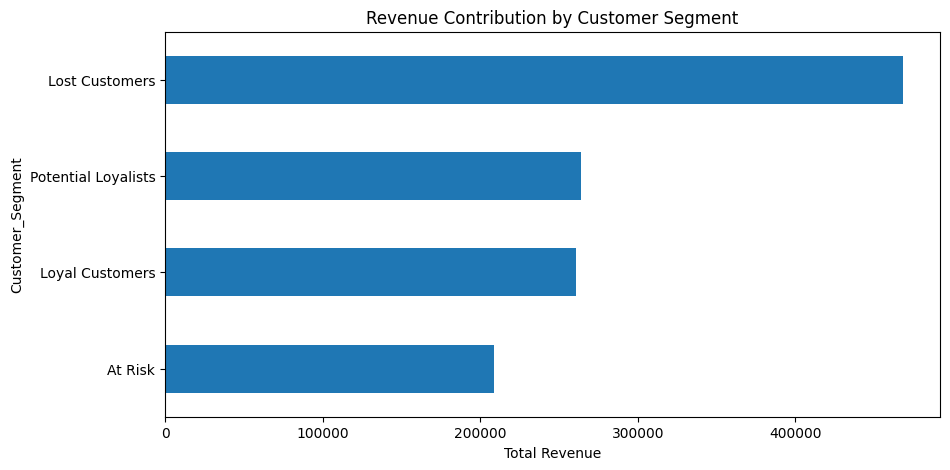

In [58]:
plt.figure(figsize=(10,5))
segment_revenue.sort_values().plot(kind='barh')
plt.title("Revenue Contribution by Customer Segment")
plt.xlabel("Total Revenue")
plt.show()


C:\Users\pooja\AppData\Local\Temp\ipykernel_9056\3555267109.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(


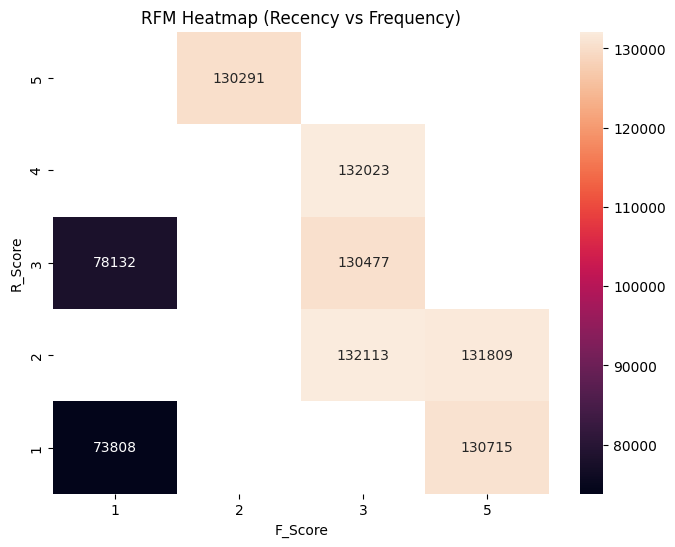

In [59]:
pivot = pd.pivot_table(
    rfm,
    values='Monetary',
    index='R_Score',
    columns='F_Score',
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".0f")
plt.title("RFM Heatmap (Recency vs Frequency)")
plt.show()


In [90]:
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['R_norm', 'F_norm', 'M_norm'])
rfm = pd.concat([rfm, rfm_scaled], axis=1)


In [91]:
rfm.to_csv("../../data/processed/rfm_final_output.csv", index=False)


In [84]:
rfm = rfm.dropna()
X = rfm[['Recency', 'Frequency', 'Monetary']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)


X_scaled shape: (10, 3)


In [85]:
Q1 = rfm['Monetary'].quantile(0.25)
Q3 = rfm['Monetary'].quantile(0.75)
IQR = Q3 - Q1

low = Q1 - 3 * IQR
high = Q3 + 3 * IQR

rfm = rfm[(rfm['Monetary'] >= low) & (rfm['Monetary'] <= high)]

print("Remaining rows:", len(rfm))


Remaining rows: 8


In [87]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
X_scaled = scaler.fit_transform(X)


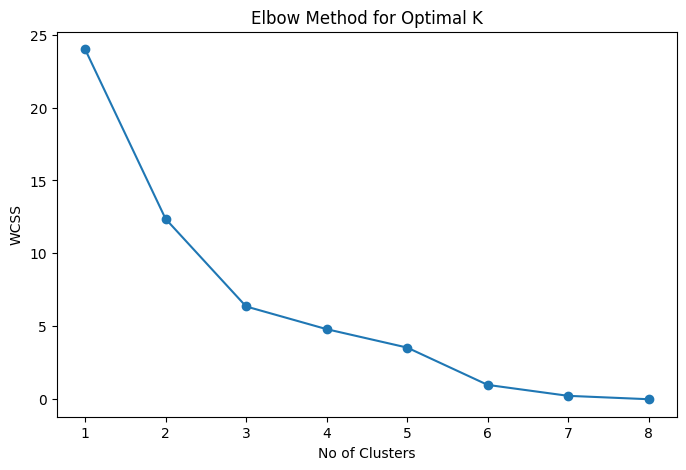

In [89]:
wcss = []

max_k = len(X_scaled)  # this is 8 in your case

for k in range(1, max_k + 1):   # now k goes only from 1 to 8
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()


In [67]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)
rfm.head()


,outlet_identifier,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment,R_norm,F_norm,M_norm,Cluster
1,OUT013,8037,932,131809.0156,2,5,4,254,Lost Customers,0.916724,0.992629,0.978162,3
2,OUT017,732,926,129103.9564,5,2,2,522,Loyal Customers,0.083390,0.977887,0.932543,2
3,OUT018,1,928,131477.7724,5,2,4,524,Loyal Customers,0.000000,0.982801,0.972576,0
5,OUT027,8767,935,130714.6746,1,5,3,153,Lost Customers,1.000000,1.000000,0.959707,1
6,OUT035,1827,930,133103.9070,4,3,5,435,Potential Loyalists,0.208305,0.987715,1.000000,3


In [68]:
rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()


,Recency,Frequency,Monetary
Cluster,,,
0,2071.000000,929.000000,130965.803467
1,8767.000000,935.000000,130714.674600
2,732.000000,926.000000,129103.956400
3,4749.333333,930.666667,132342.097467


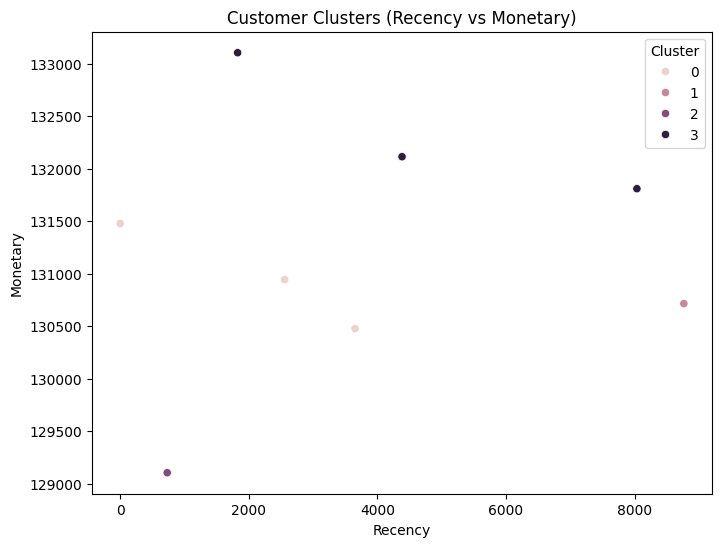

In [69]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster')
plt.title("Customer Clusters (Recency vs Monetary)")
plt.show()
